#### 21 Oct 2024
#### Temas por revisar en este Notebook:

*   * Acuerdo con profesora guía:
*   * Red todos con todos, basado en %. Definir umbral y ver comunidades/ Clusters/ Definir un tema relevante
*   * Usar df con % ponderado para todos los países
*   * Similaridad vs Influencia
*   * 

---


### Código

#### Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from networkx.algorithms import community
import community as community_louvain
from IPython.display import Markdown, display
import glob
from PIL import Image

#### Cargar el dataset de Manifesto Project al dataframe 'df'

In [2]:
file_path = "data/MPDataset_MPDS2024a.csv"
df = pd.read_csv(file_path, na_values=['', 'NaN', 'N/A', None]).fillna(0)

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9372/977512804.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, na_values=['', 'NaN', 'N/A', None]).fillna(0)


In [3]:
df.head()

,country,countryname,oecdmember,eumember,edate,date,party,partyname,partyabbrev,parfam,...,per608_3,per703_1,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion,id_perm
0,11,Sweden,0,0,17/09/1944,194409,11220,Communist Party of Sweden,SKP,20,...,0.0,0.0,0.0,9.60,1.9,1.900,0.0,1.900,2024a,JN1LZH
1,11,Sweden,0,0,17/09/1944,194409,11320,Social Democratic Labour Party,SAP,30,...,0.0,0.0,0.0,-37.80,3.3,2.200,33.4,5.600,2024a,CMR7F6
2,11,Sweden,0,0,17/09/1944,194409,11420,People’s Party,FP,40,...,0.0,0.0,0.0,9.50,3.2,6.400,14.3,1.600,2024a,Z6OL6C
3,11,Sweden,0,0,17/09/1944,194409,11620,Right Party,0,60,...,0.0,0.0,0.0,28.00,1.8,22.800,10.6,0.000,2024a,YMKVN2
4,11,Sweden,0,0,17/09/1944,194409,11810,Agrarian Party,0,80,...,0.0,0.0,0.0,23.81,0.0,19.048,0.0,4.762,2024a,U4SCRD


#### Crear campo 'agno' para registrar el año del programa de gobierno

In [4]:
# Insert column 'agno' into the dataframe, of type int, to the right of column 'date'
df.insert(df.columns.get_loc('date') + 1, 'agno', df['edate'].str[-4:].astype(int))

# List unique values of new column 'agno'
unique_agno_values = df['agno'].unique()
# print(unique_agno_values)

In [5]:
df.head()

,country,countryname,oecdmember,eumember,edate,date,agno,party,partyname,partyabbrev,...,per608_3,per703_1,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion,id_perm
0,11,Sweden,0,0,17/09/1944,194409,1944,11220,Communist Party of Sweden,SKP,...,0.0,0.0,0.0,9.60,1.9,1.900,0.0,1.900,2024a,JN1LZH
1,11,Sweden,0,0,17/09/1944,194409,1944,11320,Social Democratic Labour Party,SAP,...,0.0,0.0,0.0,-37.80,3.3,2.200,33.4,5.600,2024a,CMR7F6
2,11,Sweden,0,0,17/09/1944,194409,1944,11420,People’s Party,FP,...,0.0,0.0,0.0,9.50,3.2,6.400,14.3,1.600,2024a,Z6OL6C
3,11,Sweden,0,0,17/09/1944,194409,1944,11620,Right Party,0,...,0.0,0.0,0.0,28.00,1.8,22.800,10.6,0.000,2024a,YMKVN2
4,11,Sweden,0,0,17/09/1944,194409,1944,11810,Agrarian Party,0,...,0.0,0.0,0.0,23.81,0.0,19.048,0.0,4.762,2024a,U4SCRD


In [6]:
unique_country_count = df['countryname'].nunique()
print(f"Number of unique countries: {unique_country_count}")

Number of unique countries: 67


In [7]:
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
df_AD.head()


,Dominio,Nombre_Dominio,Variable_per,Detalle_Dominio
0,Domain_1,External Relations,per101,Foreign Special Relationships: Positive
1,Domain_1,External Relations,per102,Foreign Special Relationships: Negative
2,Domain_1,External Relations,per103,Anti-Imperialism
3,Domain_1,External Relations,per104,Military: Positive
4,Domain_1,External Relations,per105,Military: Negative


#### Agrupamos los países a 1 registro por año, sumando las variables 'perxxx'

##### Agregamos la columna 'ventana_5' para agrupar las elecciones en períodos de 5 años entre 1920 y 2023
* Período 5 años : 1920, 1925, 1930, ... 2000, 2005, 2010, 2015, 2020, 2025

In [8]:
# cargar períodos
df_ventana_10 = pd.read_excel('data/Ventana_10.xlsx')
df_ventana_5 = pd.read_excel('data/Ventana_5.xlsx')

In [9]:
# en 'df' Insertamos columnas 'ventana_10' y 'ventana_5'
df = df.merge(df_ventana_10, on='agno', how='left').rename(columns={'ventana': 'ventana_10'})
df = df.merge(df_ventana_5, on='agno', how='left').rename(columns={'ventana': 'ventana_5'})

# Get the position of the 'agno' column
agno_index = df.columns.get_loc('agno')

# Move 'ventana_10' and 'ventana_5' to the right of 'agno'
columns = list(df.columns)
columns.insert(agno_index + 1, columns.pop(columns.index('ventana_10')))
columns.insert(agno_index + 2, columns.pop(columns.index('ventana_5')))
df = df[columns]

In [ ]:
df

#### Hagamos la ponderación por año por país
#### Debemos elegir entre 'pervote' o 'presvote' para ponderar. Si existe 'presvote' usamos ese si no, 'pervote'

In [11]:
# Identificar las columnas que contienen los porcentajes
lista_columnas = [col for col in df.columns if col.startswith('per') and (col[4].isdigit() or col[6] == '_')]

# Función para calcular el promedio ponderado con base en presvote o pervote
def calcular_promedio_ponderado(grupo):
    # Si presvote contiene solo ceros o valores nulos, se usará pervote
    if (grupo['presvote'].fillna(0) == 0).all():
        peso = grupo['pervote']
        tipovoto = 'pervote'
    else:
        peso = grupo['presvote']
        tipovoto = 'presvote'

    # Si ambas están en cero o vacías
    if peso.isna().all() or (peso == 0).all():
        tipovoto = 'no hay pervote ni presvote'
        peso = pd.Series(np.ones(len(grupo)))  # usar peso 1 para calcular el promedio simple

    # Calcular el promedio ponderado para cada columna de 'lista_columnas'
    ponderado = {}
    for col in lista_columnas:
        ponderado[col] = np.average(grupo[col], weights=peso)

    # Devolver un nuevo registro con los datos
    return pd.Series(
        [grupo['agno'].iloc[0], grupo['countryname'].iloc[0], grupo['ventana_10'].iloc[0], 
         grupo['ventana_5'].iloc[0], tipovoto] + list(ponderado.values()),
        index=['agno', 'countryname', 'ventana_10', 'ventana_5', 'tipovoto'] + lista_columnas
    )

# Agrupar por countryname y agno, y aplicar la función de promedio ponderado
df_ponderado = df.groupby(['countryname', 'agno']).apply(calcular_promedio_ponderado).reset_index(drop=True)


In [12]:
df_ponderado

,agno,countryname,ventana_10,ventana_5,tipovoto,per101,per102,per103,per104,per105,...,per606_1,per606_2,per607_1,per607_2,per607_3,per608_1,per608_2,per608_3,per703_1,per703_2
0,1991,Albania,190,15,pervote,2.140848,0.000000,1.559835,0.581013,0.193536,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,1992,Albania,190,15,pervote,0.972966,0.000000,0.000000,1.465758,0.137749,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,1996,Albania,190,16,pervote,1.945808,0.000000,0.020491,0.472585,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,1997,Albania,190,16,pervote,1.770988,0.000000,0.031388,3.046506,0.015910,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,2001,Albania,200,17,pervote,2.392570,0.000000,0.000000,2.757403,0.026619,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,2008,United States,200,18,pervote,1.978711,0.088485,0.044020,5.839310,0.088485,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
842,2012,United States,210,19,presvote,0.505120,0.161887,0.189797,7.527242,1.491961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
843,2016,United States,210,20,presvote,0.866280,0.111349,0.000000,5.807609,0.763045,...,0.803674,0.088884,0.160093,0.263441,1.787391,0.022465,0.078721,0.0,1.657539,0.022465
844,2020,United States,220,21,presvote,1.190682,0.129249,0.161450,5.565559,1.951804,...,0.449422,0.086907,0.547069,0.082574,1.909957,0.021965,0.043453,0.0,1.991430,0.021965


#### Ordenemos el dataset según períodos de 5 años. Para  cada país, se sumarán los valores de las variables de aquellos años dengtro del período


In [13]:
# Cambiemos el nombre a 'df_f
df_f = df_ponderado.copy()


#### df_5: Consolidamos por país y por 'ventana_5'

In [14]:
# Crear el dataframe 'df_5' sumando los valores de las columnas que comienzan con 'per' agrupados por 'countryname' y 'ventana_5'
df_5 = df_f.groupby(['countryname', 'ventana_5'])[lista_columnas].sum().reset_index()

# Mostrar las primeras filas del nuevo dataframe 'df_5'
df_5


,countryname,ventana_5,per101,per102,per103,per104,per105,per106,per107,per108,...,per606_1,per606_2,per607_1,per607_2,per607_3,per608_1,per608_2,per608_3,per703_1,per703_2
0,Albania,15,3.113815,0.000000,1.559835,2.046771,0.331285,1.674371,4.632186,5.169904,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,Albania,16,3.716797,0.000000,0.051879,3.519091,0.015910,0.579077,4.971347,1.981720,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,Albania,17,2.392570,0.000000,0.000000,2.757403,0.026619,0.023948,3.523162,1.452779,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,Argentina,14,0.000000,0.000000,4.619213,0.448618,0.828036,0.338070,2.955090,0.000000,...,7.595332,0.000000,0.326532,0.000000,0.000000,0.000000,0.000000,0.0,2.495280,0.000000
4,Argentina,16,0.254185,0.020140,0.725611,1.406834,0.100835,1.720736,5.478894,3.932102,...,4.494125,0.000000,0.443809,0.000000,0.809128,0.000000,0.000000,0.0,2.573783,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,United States,18,1.978711,0.088485,0.044020,5.839310,0.088485,1.308294,8.863648,0.343947,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
600,United States,19,0.505120,0.161887,0.189797,7.527242,1.491961,0.658037,6.073936,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
601,United States,20,0.866280,0.111349,0.000000,5.807609,0.763045,0.635581,4.669601,0.000000,...,0.803674,0.088884,0.160093,0.263441,1.787391,0.022465,0.078721,0.0,1.657539,0.022465
602,United States,21,1.190682,0.129249,0.161450,5.565559,1.951804,0.480557,3.907785,0.020377,...,0.449422,0.086907,0.547069,0.082574,1.909957,0.021965,0.043453,0.0,1.991430,0.021965


In [15]:
df_5.shape

(604, 144)

In [16]:
all_per_variables = [col for col in df_5.columns if col.startswith('per')]
all_per_variables

['per101',
 'per102',
 'per103',
 'per104',
 'per105',
 'per106',
 'per107',
 'per108',
 'per109',
 'per110',
 'per201',
 'per202',
 'per203',
 'per204',
 'per301',
 'per302',
 'per303',
 'per304',
 'per305',
 'per401',
 'per402',
 'per403',
 'per404',
 'per405',
 'per406',
 'per407',
 'per408',
 'per409',
 'per410',
 'per411',
 'per412',
 'per413',
 'per414',
 'per415',
 'per416',
 'per501',
 'per502',
 'per503',
 'per504',
 'per505',
 'per506',
 'per507',
 'per601',
 'per602',
 'per603',
 'per604',
 'per605',
 'per606',
 'per607',
 'per608',
 'per701',
 'per702',
 'per703',
 'per704',
 'per705',
 'per706',
 'per1011',
 'per1012',
 'per1013',
 'per1014',
 'per1015',
 'per1016',
 'per1021',
 'per1022',
 'per1023',
 'per1024',
 'per1025',
 'per1026',
 'per1031',
 'per1032',
 'per1033',
 'per2021',
 'per2022',
 'per2023',
 'per2031',
 'per2032',
 'per2033',
 'per2041',
 'per3011',
 'per3051',
 'per3052',
 'per3053',
 'per3054',
 'per3055',
 'per4011',
 'per4012',
 'per4013',
 'per4014',


#### df_5_extended: Agreguemos registros cero para todos los países para los períodos en que no hay información. Esto da consistencia en la comparación, se refleja que para ciertos períodos no hay datos lo que evita sesgo en la comparación, y mantiene la uniformidad en la red de similaridad

In [17]:
# Paso 1: Obtener la lista de todos los países en el dataframe
all_countries = df_5['countryname'].unique()

# Paso 2: Crear un DataFrame con todos los períodos posibles (1 al 21)
all_periods = pd.DataFrame({'ventana_5': list(range(1, 22))})

# Paso 3: Crear un DataFrame vacío para almacenar los registros faltantes
missing_periods_all = pd.DataFrame()

# Paso 4: Iterar sobre todos los países y generar registros con ceros para los períodos faltantes
for country in all_countries:
    # Filtrar los períodos existentes del país en df_5
    existing_periods = df_5[df_5['countryname'] == country]['ventana_5'].unique()
    
    # Determinar los períodos faltantes para el país
    missing_periods = all_periods[~all_periods['ventana_5'].isin(existing_periods)]
    
    # Crear registros con valores cero para los períodos faltantes
    missing_data = pd.DataFrame({
        'countryname': [country] * len(missing_periods),
        'ventana_5': missing_periods['ventana_5']
    })
    
    # Asignar valores cero a todas las variables 'per'
    for col in all_per_variables:
        missing_data[col] = 0.0
    
    # Agregar los registros faltantes al DataFrame total
    missing_periods_all = pd.concat([missing_periods_all, missing_data], ignore_index=True)

# Paso 5: Combinar los registros faltantes con el DataFrame original
df_5_extended = pd.concat([df_5, missing_periods_all], ignore_index=True)

# Paso 6: Verificar que ahora todos los países tengan datos para todos los períodos
df_5_extended.groupby('countryname')['ventana_5'].nunique()


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9372/2392521840.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  missing_data[col] = 0.0
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9372/2392521840.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  missing_data[col] = 0.0
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9372/2392521840.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

countryname
Albania           21
Argentina         21
Armenia           21
Australia         21
Austria           21
                  ..
Turkey            21
Ukraine           21
United Kingdom    21
United States     21
Uruguay           21
Name: ventana_5, Length: 67, dtype: int64

In [18]:
df_5_extended.head()

,countryname,ventana_5,per101,per102,per103,per104,per105,per106,per107,per108,...,per606_1,per606_2,per607_1,per607_2,per607_3,per608_1,per608_2,per608_3,per703_1,per703_2
0,Albania,15,3.113815,0.00000,1.559835,2.046771,0.331285,1.674371,4.632186,5.169904,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,Albania,16,3.716797,0.00000,0.051879,3.519091,0.015910,0.579077,4.971347,1.981720,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,Albania,17,2.392570,0.00000,0.000000,2.757403,0.026619,0.023948,3.523162,1.452779,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,Argentina,14,0.000000,0.00000,4.619213,0.448618,0.828036,0.338070,2.955090,0.000000,...,7.595332,0.0,0.326532,0.0,0.000000,0.0,0.0,0.0,2.495280,0.0
4,Argentina,16,0.254185,0.02014,0.725611,1.406834,0.100835,1.720736,5.478894,3.932102,...,4.494125,0.0,0.443809,0.0,0.809128,0.0,0.0,0.0,2.573783,0.0


### Correlación de Pearson y Threshold

#### Correlación de Pearson

**Qué es**: La correlación de Pearson mide la relación lineal entre dos conjuntos de datos. En este caso, mediría cómo se correlacionan los porcentajes de las etiquetas temáticas entre dos programas de gobierno.

**Aplicación**: Para cada par de programas de gobierno (por ejemplo, "Chile_1990" y "Alemania_1980"), calcula la correlación de Pearson usando sus respectivos vectores de porcentajes de las 56 etiquetas temáticas.

Si el vector de "Chile_1990" es `[x1,x2,...,x56]` y el de "Alemania_1980" es `[y1,y2,...,y56]`, entonces la correlación de Pearson se calcula como:

$$
r = \frac{\sum_{i=1}^{56} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{56} (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^{56} (y_i - \bar{y})^2}}
$$

Donde $\bar{x}$ y $\bar{y}$ son las medias de los vectores de porcentajes.

#### Interpretación de la Correlación:
El valor de $r$ está en el rango $[-1,1]$, donde:

- $r = 1$ indica una correlación positiva perfecta (discursos muy similares en la distribución temática).
- $r = -1$ indica una correlación negativa perfecta (discursos temáticamente opuestos).
- $r \approx 0$ indica que no hay una correlación lineal significativa.

#### Uso en la Red de Similaridad:
Usaremos el valor absoluto de la correlación ($|r|$) para ponderar la arista entre dos programas. Valores cercanos a 1 indican una fuerte similaridad temática, mientras que valores cercanos a 0 indican poca o ninguna similaridad.

---


### CREEMOS LA RED

#### Los nodos son pares país-período, y los enlaces son la correlación entre ambos. Todos con Todos. Feature vector completo

#### PASO 1: CÁLCULO DE CORRELACIÓN Todos con Todos

In [ ]:
# CORRELATION MATRIX

from scipy.stats import spearmanr
from tqdm import tqdm  # Librería para visualizar el progreso

# Crear un identificador único para cada par de 'countryname' y 'ventana_5'
df_5_extended['pair'] = df_5_extended['countryname'] + '_' + df_5_extended['ventana_5'].astype(str)

# Filtrar solo las columnas 'per' y la columna 'pair'
columns_per = [col for col in df_5_extended.columns if col.startswith('per')]
df_corr = df_5_extended.set_index('pair')[columns_per]

# Crear un dataframe para almacenar las correlaciones
correlation_matrix = pd.DataFrame(index=df_corr.index, columns=df_corr.index)

# Calcular el número total de combinaciones de pares
total_combinations = len(df_corr) * (len(df_corr) - 1) / 2

# Calcular la correlación de Spearman para cada par con cada par utilizando una única barra de progreso
try:
    with tqdm(total=total_combinations, desc="Calculando correlaciones de Spearman") as pbar:
        for i, pair1 in enumerate(df_corr.index):
            country1 = pair1.split('_')[0]  # Extraer el nombre del país del par1
            for j, pair2 in enumerate(df_corr.index[i+1:], start=i+1):  # Evitar repeticiones y calcular solo una vez por par
                country2 = pair2.split('_')[0]  # Extraer el nombre del país del par2

                # Verificar si ambos pares pertenecen al mismo país
                if country1 == country2:
                    corr = 0  # Asignar correlación 0 para pares del mismo país
                else:
                    # Verificar si ambas filas tienen solo ceros
                    if (df_corr.loc[pair1].sum() == 0) and (df_corr.loc[pair2].sum() == 0):
                        corr = 0  # Asignar correlación 0 cuando ambos pares son completamente ceros
                    else:
                        # Calcular la correlación de Spearman
                        corr, _ = spearmanr(df_corr.loc[pair1], df_corr.loc[pair2])
                        if pd.isna(corr):  # Si la correlación da NaN, asignar 0
                            corr = 0
                
                # Asignar la correlación calculada
                correlation_matrix.loc[pair1, pair2] = corr
                correlation_matrix.loc[pair2, pair1] = corr  # Reflejar la correlación en ambas direcciones
                pbar.update(1)

    # Rellenar con unos las correlaciones consigo mismo (diagonal)
    for pair in df_corr.index:
        correlation_matrix.loc[pair, pair] = 1.0

except KeyboardInterrupt:
    print("Proceso interrumpido por el usuario.")
    # Aquí puedes optar por guardar el progreso actual o realizar alguna otra acción.


In [ ]:
correlation_matrix

#### Guardamos el correlation_matrix

In [118]:
# Guardar el dataframe en un archivo Excel
correlation_matrix.to_excel('correlation_matrix.xlsx', index=True)  # 'index=True' para guardar los índices del dataframe


#### Cargamos desde el excel

In [19]:
# Cargar el dataframe desde un archivo Excel
correlation_matrix = pd.read_excel('correlation_matrix.xlsx', index_col=0)  # 'index_col=0' para cargar la columna de índice correctamente


In [20]:
correlation_matrix.head()

,Albania_15,Albania_16,Albania_17,Argentina_14,Argentina_16,Argentina_17,Argentina_18,Argentina_19,Argentina_20,Armenia_16,...,Uruguay_11,Uruguay_12,Uruguay_13,Uruguay_14,Uruguay_15,Uruguay_16,Uruguay_17,Uruguay_18,Uruguay_20,Uruguay_21
pair,,,,,,,,,,,,,,,,,,,,,
Albania_15,1.000000,0.000000,0.000000,0.553442,0.575908,0.554576,0.527684,0.519215,0.540114,0.803857,...,0,0,0,0,0,0,0,0,0,0
Albania_16,0.000000,1.000000,0.000000,0.468196,0.507012,0.487507,0.495225,0.426757,0.457873,0.705638,...,0,0,0,0,0,0,0,0,0,0
Albania_17,0.000000,0.000000,1.000000,0.471237,0.526964,0.522082,0.511389,0.430358,0.478863,0.711718,...,0,0,0,0,0,0,0,0,0,0
Argentina_14,0.553442,0.468196,0.471237,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.604121,...,0,0,0,0,0,0,0,0,0,0
Argentina_16,0.575908,0.507012,0.526964,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.627385,...,0,0,0,0,0,0,0,0,0,0


#### VERIFIQUEMOS LA SANIDAD DE LA MATRIZ DE CORRELACIONES

##### Veamos si hay valores nulos en la matriz

In [21]:
# Verificar si hay valores nulos en la matriz de correlaciones
if correlation_matrix.isnull().values.any():
    print("Hay valores nulos en la matriz de correlaciones. Revisa los datos.")
else:
    print("No hay valores nulos en la matriz de correlaciones.")


No hay valores nulos en la matriz de correlaciones.


#### Veamos si la matriz es simétrica

In [22]:
# Verificar si la matriz de correlaciones es simétrica
if (correlation_matrix == correlation_matrix.T).all().all():
    print("La matriz de correlaciones es simétrica.")
else:
    print("La matriz de correlaciones NO es simétrica. Revisa los cálculos.")


La matriz de correlaciones es simétrica.


#### Calculemos el número de correlaciones calculadas (excluyendo la diagonal)

In [23]:
# Número de pares únicos
N = len(correlation_matrix)

# Contar el número de correlaciones distintas de 1.0, excluyendo la diagonal
correlations_calculated = (correlation_matrix != 1).sum().sum() / 2  # Dividir por 2 para evitar dobles conteos

# Número total esperado de correlaciones (excluyendo la diagonal)
expected_correlations = (N * (N - 1)) / 2

if correlations_calculated == expected_correlations:
    print(f"Se calcularon todas las correlaciones correctamente. Total: {int(correlations_calculated)}")
else:
    print(f"Faltan correlaciones. Calculadas: {int(correlations_calculated)}, Esperadas: {int(expected_correlations)}")


Se calcularon todas las correlaciones correctamente. Total: 989121


#### Imprimamos  una muestra aleatoria de correlaciones

In [24]:
# Mostrar una muestra aleatoria de 5 pares de correlaciones
sample = correlation_matrix.sample(5, axis=0).sample(5, axis=1)
print("Muestra aleatoria de correlaciones:")
print(sample)


Muestra aleatoria de correlaciones:
                 Poland_12  Portugal_9  Finland_17  Hungary_21  Ukraine_19
pair                                                                      
Croatia_9                0           0    0.000000           0    0.000000
Estonia_1                0           0    0.000000           0    0.000000
Malta_1                  0           0    0.000000           0    0.000000
South Africa_20          0           0    0.675559           0    0.875654
Croatia_11               0           0    0.000000           0    0.000000


#### THRESHOLD

In [93]:
threshold = 0.85  # Umbral para considerar dos países como altamente correlacionados

#### PASO 2: HEATMAP

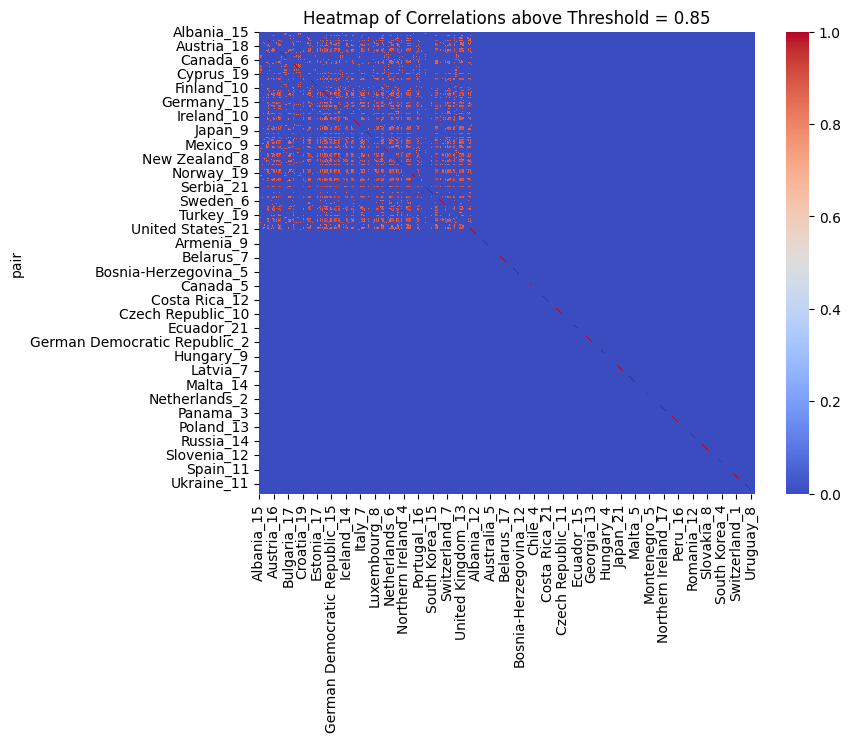

THRESHOLD = 0.85


In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(correlation_matrix, threshold):
    # Aplicar el threshold
    filtered_corr = correlation_matrix[correlation_matrix >= threshold].fillna(0)
    
    # Plotear el heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(filtered_corr, cmap='coolwarm', annot=False, cbar=True)
    plt.title(f"Heatmap of Correlations above Threshold = {threshold}")
    plt.show()

# Usar la función con un threshold definido
plot_heatmap(correlation_matrix, threshold)
print(f"THRESHOLD = {threshold}")


#### PASO 3: IDENTIFICACIÓN DE COMUNIDADES

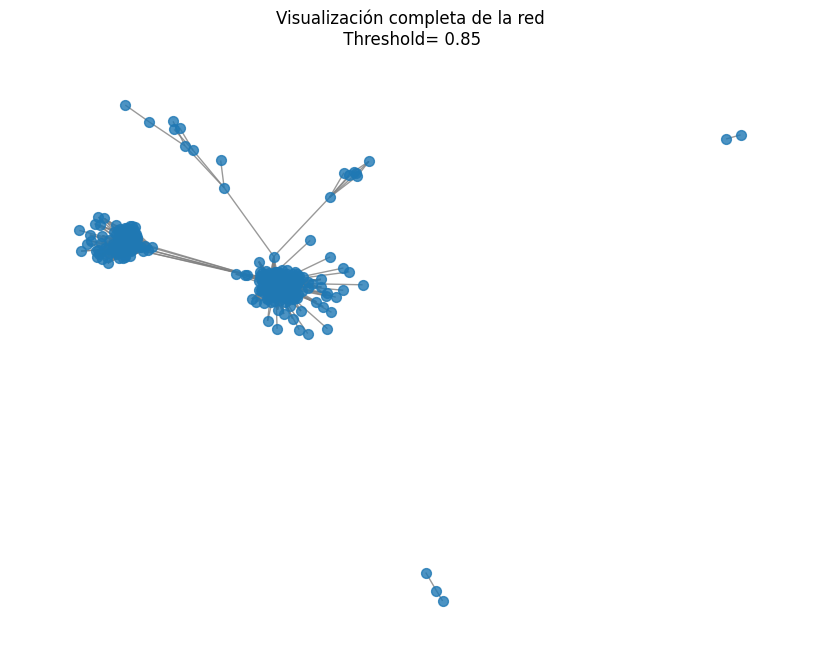

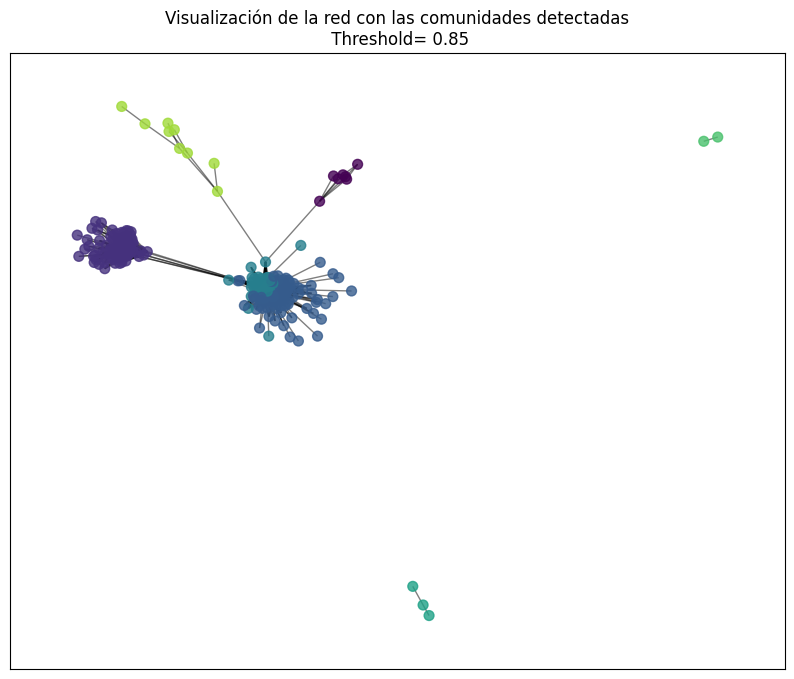

THRESHOLD = 0.85


In [95]:
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt
import pandas as pd

# Crear un grafo a partir de las correlaciones
def create_graph(correlation_matrix, threshold):
    graph = nx.Graph()
    for pair1 in correlation_matrix.index:
        for pair2 in correlation_matrix.columns:
            if pair1 != pair2 and correlation_matrix.loc[pair1, pair2] >= threshold:
                graph.add_edge(pair1, pair2, weight=correlation_matrix.loc[pair1, pair2])
    return graph

# Crear el grafo

graph = create_graph(correlation_matrix, threshold)

# Visualización de la red completa (sin colorear comunidades)
def visualize_full_graph(graph):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(graph, seed=42)  # Disposición de los nodos
    nx.draw(graph, pos, node_size=50, alpha=0.8, edge_color='grey')
    plt.title(f"Visualización completa de la red\n Threshold= {threshold}")
    plt.show()

# Visualización de la red con comunidades
def visualize_graph_with_communities(graph, partition):
    # Obtener los colores para las comunidades
    cmap = plt.get_cmap('viridis')
    unique_communities = list(set(partition.values()))
    color_map = [cmap(i / len(unique_communities)) for i in partition.values()]
    
    # Dibujar el grafo
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph, seed=42)  # Disposición de los nodos
    nx.draw_networkx_nodes(graph, pos, node_color=color_map, node_size=50, alpha=0.8)
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    plt.title(f"Visualización de la red con las comunidades detectadas\n Threshold= {threshold}")
    plt.show()

# Función para crear un dataframe con las comunidades, nodos y correlaciones
def create_community_dataframe(graph, partition, correlation_matrix):
    communities_data = []

    for node, community in partition.items():
        connected_nodes = list(graph.neighbors(node))
        for other_node in connected_nodes:
            correlation = correlation_matrix.loc[node, other_node]
            communities_data.append({
                'Community': community,
                'Node': node,
                'Other_Node': other_node,
                'Correlation': correlation
            })

    # Crear un dataframe a partir de los datos de las comunidades
    df_communities = pd.DataFrame(communities_data)
    return df_communities

# Llamar a las funciones para visualizar la red completa y con comunidades
visualize_full_graph(graph)

# Detección de comunidades
partition = community_louvain.best_partition(graph)

visualize_graph_with_communities(graph, partition)

# Crear y mostrar el dataframe de comunidades
df_communities = create_community_dataframe(graph, partition, correlation_matrix)
print(f"THRESHOLD = {threshold}")


In [96]:
df_communities

,Community,Node,Other_Node,Correlation
0,0,Albania_15,Hungary_15,0.864059
1,0,Hungary_15,Albania_15,0.864059
2,0,Hungary_15,Bulgaria_15,0.917113
3,0,Hungary_15,Czech Republic_15,0.862383
4,0,Hungary_15,Czech Republic_19,0.859860
...,...,...,...,...
50641,4,North Macedonia_15,Montenegro_15,0.858911
50642,4,Serbia_15,Montenegro_15,0.915082
50643,5,North Macedonia_16,Romania_16,0.883130
50644,5,Romania_16,North Macedonia_16,0.883130


#### Veamos qué nodos hay en cada comunidad

In [97]:
# Función para listar los nodos de cada comunidad
def list_nodes_per_community(partition):
    # Crear un diccionario para almacenar los nodos por comunidad
    community_nodes = {}
    for node, community in partition.items():
        if community not in community_nodes:
            community_nodes[community] = []
        community_nodes[community].append(node)
    
    # Convertir el diccionario en un dataframe
    df_community_nodes = pd.DataFrame([
        {'Community': community, 'Nodes': nodes}
        for community, nodes in community_nodes.items()
    ])
    
    return df_community_nodes

# Llamar a la función para listar los nodos por comunidad
df_community_nodes = list_nodes_per_community(partition)
df_community_nodes


,Community,Nodes
0,0,"[Albania_15, Hungary_15, Bulgaria_15, Czech Re..."
1,1,"[Argentina_14, Brazil_16, Colombia_19, Croatia..."
2,2,"[Armenia_16, Australia_16, Georgia_16, Netherl..."
3,3,"[Canada_19, Ireland_18, Malta_16, North Macedo..."
4,6,"[Czech Republic_16, Hungary_16, Slovenia_17, C..."
5,4,"[Montenegro_15, North Macedonia_15, Serbia_15]"
6,5,"[North Macedonia_16, Romania_16]"


In [98]:
# Función para contar el número de nodos por comunidad
def count_nodes_per_community(partition):
    # Contar el número de nodos en cada comunidad
    community_counts = {}
    for community in set(partition.values()):
        community_counts[community] = list(partition.values()).count(community)
    
    # Crear un dataframe para mostrar los resultados
    df_community_counts = pd.DataFrame(list(community_counts.items()), columns=['Community', 'Number of Nodes'])
    
    return df_community_counts

# Llamar a la función para contar los nodos por comunidad
df_community_counts = count_nodes_per_community(partition)

df_community_counts


,Community,Number of Nodes
0,0,7
1,1,129
2,2,184
3,3,170
4,4,3
5,5,2
6,6,9


#### COMUNIDADES EN QUE ESTÁ CHILE

In [99]:
# Filtrar las comunidades donde aparece 'Chile' en los nodos
comunidades_con_chile = df_community_nodes[df_community_nodes['Nodes'].apply(lambda x: any('Chile' in nodo for nodo in x))]

# Obtener el número de comunidades donde está presente 'Chile'
num_comunidades_chile = len(comunidades_con_chile)

# Obtener los números de esas comunidades
numeros_comunidades_chile = comunidades_con_chile['Community'].tolist()

# Mostrar el resultado
print(f"El total de comunidades es: {len(df_community_nodes)}")
print(f"Chile está presente en {num_comunidades_chile} comunidad(es).")
print(f"El(los) número(s) de la(s) comunidad(es) donde está Chile es(son): {numeros_comunidades_chile}")


El total de comunidades es: 7
Chile está presente en 1 comunidad(es).
El(los) número(s) de la(s) comunidad(es) donde está Chile es(son): [1]


#### Grafiquemos el cluster donde está Chile (rojo)

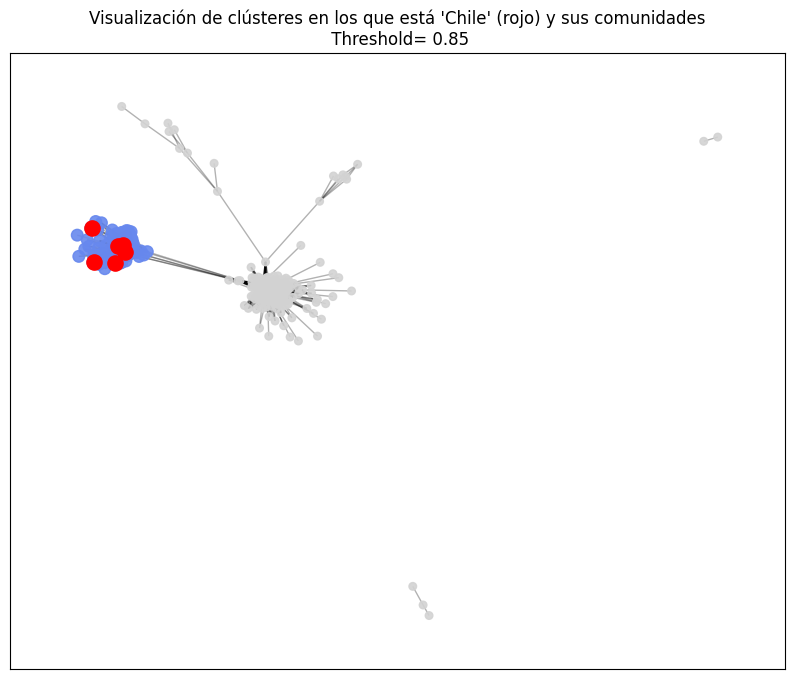

In [100]:
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt

# Visualización de la red con comunidades, destacando los clústeres de Chile
def visualize_chile_clusters(graph, partition, country='Chile'):
    # Obtener los nodos que contienen el nombre del país especificado
    chile_nodes = [node for node in graph.nodes if country in node]
    
    # Obtener las comunidades de esos nodos
    chile_communities = set(partition[node] for node in chile_nodes)
    
    # Crear un mapa de colores para las comunidades de Chile
    cmap = plt.get_cmap('coolwarm')
    unique_communities = list(set(partition.values()))
    node_color_map = {community: cmap(i / len(unique_communities)) for i, community in enumerate(unique_communities)}
    
    # Colores para los nodos: destacamos los nodos de Chile y sus comunidades
    node_colors = []
    node_sizes = []
    for node in graph.nodes:
        if partition[node] in chile_communities:
            node_colors.append(node_color_map[partition[node]])
            node_sizes.append(100 if node in chile_nodes else 70)  # Tamaño mayor para los nodos de Chile
        else:
            node_colors.append("lightgrey")  # Nodos que no pertenecen a las comunidades de Chile
            node_sizes.append(30)
    
    # Dibujar el grafo
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph, seed=42)  # Disposición de los nodos
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(graph, pos, alpha=0.3)
    
    # Destacar los nodos de Chile
    nx.draw_networkx_nodes(graph, pos, nodelist=chile_nodes, node_color='red', node_size=120, alpha=1.0)
    
    plt.title(f"Visualización de clústeres en los que está '{country}' (rojo) y sus comunidades\n Threshold= {threshold}")
    plt.show()

# Llamar a la función para visualizar los clústeres de Chile
visualize_chile_clusters(graph, partition, country='Chile')


#### Veamos los clusters donde está Chile, y con quién

In [101]:
import pandas as pd

def create_chile_communities_df(graph, partition, correlation_matrix, threshold, country='Chile'):
    # Obtener los nodos que contienen el nombre del país especificado
    chile_nodes = [node for node in graph.nodes if country in node]
    
    # Obtener las comunidades a las que pertenecen los nodos de Chile
    chile_communities = set(partition[node] for node in chile_nodes)
    
    # Crear una lista para almacenar los datos de las comunidades de Chile
    communities_data = []
    
    # Recorrer las comunidades de Chile y sus conexiones
    for community in chile_communities:
        # Obtener los nodos de la misma comunidad
        community_nodes = [node for node, comm in partition.items() if comm == community]
        
        for chile_node in chile_nodes:
            for other_node in community_nodes:
                if chile_node != other_node:
                    # Verificar si la correlación es mayor o igual al threshold
                    correlation = correlation_matrix.loc[chile_node, other_node]
                    if correlation >= threshold:
                        communities_data.append({
                            'Community': community,
                            'Chile_Node': chile_node,
                            'Other_Node': other_node,
                            'Correlation': correlation
                        })
    
    # Crear un dataframe con la información
    df_chile_communities = pd.DataFrame(communities_data)
    
    return df_chile_communities

# Llamar a la función para crear el dataframe de comunidades de Chile con el threshold
df_chile_communities = create_chile_communities_df(graph, partition, correlation_matrix, threshold, country='Chile')


In [102]:
print(f"\n THRESHOLD = {threshold}")
df_chile_communities


 THRESHOLD = 0.85


,Community,Chile_Node,Other_Node,Correlation
0,1,Chile_14,Brazil_16,0.873365
1,1,Chile_14,Colombia_19,0.880822
2,1,Chile_14,Peru_19,0.853646
3,1,Chile_14,Argentina_16,0.862679
4,1,Chile_14,Bosnia-Herzegovina_19,0.874331
...,...,...,...,...
185,1,Chile_21,Bolivia_18,0.871915
186,1,Chile_21,Montenegro_21,0.851020
187,1,Chile_21,Panama_19,0.852856
188,1,Chile_15,Montenegro_20,0.853148


#### _____________________________

In [103]:
correlation_matrix

,Albania_15,Albania_16,Albania_17,Argentina_14,Argentina_16,Argentina_17,Argentina_18,Argentina_19,Argentina_20,Armenia_16,...,Uruguay_11,Uruguay_12,Uruguay_13,Uruguay_14,Uruguay_15,Uruguay_16,Uruguay_17,Uruguay_18,Uruguay_20,Uruguay_21
pair,,,,,,,,,,,,,,,,,,,,,
Albania_15,1.000000,0.000000,0.000000,0.553442,0.575908,0.554576,0.527684,0.519215,0.540114,0.803857,...,0,0,0,0,0,0,0,0,0,0
Albania_16,0.000000,1.000000,0.000000,0.468196,0.507012,0.487507,0.495225,0.426757,0.457873,0.705638,...,0,0,0,0,0,0,0,0,0,0
Albania_17,0.000000,0.000000,1.000000,0.471237,0.526964,0.522082,0.511389,0.430358,0.478863,0.711718,...,0,0,0,0,0,0,0,0,0,0
Argentina_14,0.553442,0.468196,0.471237,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.604121,...,0,0,0,0,0,0,0,0,0,0
Argentina_16,0.575908,0.507012,0.526964,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.627385,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uruguay_16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
Uruguay_17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
Uruguay_18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,1,0,0


#### PASO 4: MÉTRICAS DE CENTRALIDAD

#### Degree Centrality

**Degree Centrality** mide la fracción de nodos a los que un nodo específico está directamente conectado. Se calcula como el número de nodos a los que está directamente conectado, dividido por el número total de nodos menos uno (porque un nodo no se conecta consigo mismo).

La centralidad de grado indica la importancia de un nodo en términos de cuántos enlaces tiene. Un nodo con un grado alto puede interpretarse como un nodo "popular" o "conectado" directamente con muchos otros nodos.

- <span style="color:red;">Si un nodo representa un país_período, un alto valor de Degree Centrality indica que el programa de gobierno de ese nodo está muy conectado con otros programas de gobierno en el grafo de similaridad.</span>

-
-

  $$\text{Degree Centrality} = \frac{\text{Número de conexiones directas}}{\text{Número total de nodos} - 1}$$
---


#### Betweenness Centrality

**Betweenness Centrality** mide la cantidad de veces que un nodo actúa como un puente crítico a lo largo del camino más corto entre dos otros nodos. Es una métrica de centralidad que indica la influencia de un nodo en la red al facilitar la comunicación entre diferentes partes de la red. De otra manera, mide la importancia de un nodo en términos de su capacidad para conectar a otros nodos indirectamente. indica la capacidad de un nodo de controlar el flujo de información en la red, al estar en el camino de múltiples nodos. Un nodo con alta betweenness centrality puede ser un punto clave de conexión y podría tener una mayor influencia en la red.
- Esta métrica es útil para identificar nodos que son fundamentales para la comunicación entre diferentes comunidades o regiones en la red.

- La **Betweenness Centrality** de un nodo se calcula como la fracción de todos los caminos más cortos entre cualquier par de nodos que pasan por dicho nodo.

- <span style="color:red;">Un nodo país_período con un alto valor de Betweenness Centrality indica que el programa de gobierno correspondiente a ese nodo juega un rol clave en conectar diferentes programas de otros países.</span>

#### Cálculo de Betweenness Centrality:
- Para un nodo \( v \), su betweenness centrality se define como:

  $$\text{Betweenness Centrality}(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}$$

  Donde:
  - \( \sigma_{st} \) es el número total de caminos más cortos entre los nodos \( s \) y \( t \).
  - \( \sigma_{st}(v) \) es el número de esos caminos más cortos que pasan por el nodo \( v \).
---


#### Closeness Centrality

**Closeness Centrality** mide qué tan cerca está un nodo de todos los demás nodos en términos de distancia de red. Cuanto mayor sea la centralidad de cercanía de un nodo, menor es la distancia promedio entre ese nodo y todos los demás nodos en la red. Es una métrica que indica la eficiencia con la que un nodo puede acceder a los otros nodos de la red.

- Un nodo con alta **Closeness Centrality** tiene una menor distancia media hacia todos los demás nodos, lo que implica que puede influir o ser influenciado por otros nodos de manera rápida y directa.
- Esta métrica es útil para identificar nodos que están estratégicamente ubicados para difundir información o recursos de manera eficiente dentro de la red.
- Un nodo con alta **Closeness Centrality** puede ser un buen punto de distribución o comunicación en la red, ya que está "cerca" de los demás nodos en términos de distancia.
- Esto significa que este nodo puede alcanzar rápidamente a otros nodos, lo que es ventajoso en una red donde la rapidez de la transmisión de información o la influencia es clave.

- <span style="color:red;">Un nodo país_período con un alto valor de Closeness Centrality indica que el programa de gobierno de ese nodo está cerca de muchos otros programas, lo que sugiere que puede influir o ser influenciado por otros programas con facilidad.</span>


#### Cálculo de Closeness Centrality:
- Para un nodo \( v \), su **Closeness Centrality** se define como la inversa de la suma de todas las distancias más cortas desde \( v \) a todos los demás nodos:

  
  $$\text{Closeness Centrality}(v) = \frac{1}{\sum_{u \neq v} d(v, u)}$$
  

  Donde:
  - \( d(v, u) \) es la distancia más corta entre el nodo \( v \) y el nodo \( u \).
  - La suma se toma sobre todos los nodos \( u \) diferentes de \( v \).

---

In [104]:
# Calcular diferentes métricas de centralidad
degree_centrality = nx.degree_centrality(graph)
betweenness_centrality = nx.betweenness_centrality(graph)
closeness_centrality = nx.closeness_centrality(graph)

# Convertir a dataframe para visualización
centrality_df = pd.DataFrame({
    'Degree Centrality': degree_centrality,
    'Betweenness Centrality': betweenness_centrality,
    'Closeness Centrality': closeness_centrality
})

centrality_df


,Degree Centrality,Betweenness Centrality,Closeness Centrality
Albania_15,0.001988,0.000000,0.214090
Hungary_15,0.011928,0.023453,0.273006
Argentina_14,0.007952,0.000000,0.254149
Brazil_16,0.117296,0.002683,0.293657
Colombia_19,0.145129,0.011132,0.337705
...,...,...,...
North Macedonia_15,0.001988,0.000000,0.002651
Serbia_15,0.001988,0.000000,0.002651
North Macedonia_16,0.001988,0.000000,0.001988
Romania_16,0.001988,0.000000,0.001988


In [105]:
centrality_df.describe()

,Degree Centrality,Betweenness Centrality,Closeness Centrality
count,504.000000,504.000000,504.000000
mean,0.199778,0.003353,0.381826
std,0.162305,0.013994,0.091824
min,0.001988,0.000000,0.001988
25%,0.057654,0.000060,0.307006
50%,0.140159,0.000560,0.395710
75%,0.359841,0.002378,0.454948
max,0.516899,0.175763,0.553367


In [106]:
# Guardar el dataframe como archivo Excel
centrality_df.to_excel('centrality_df.xlsx', index=True)


#### Analicemos los principales según cada métrica y veamos el rol de Chile

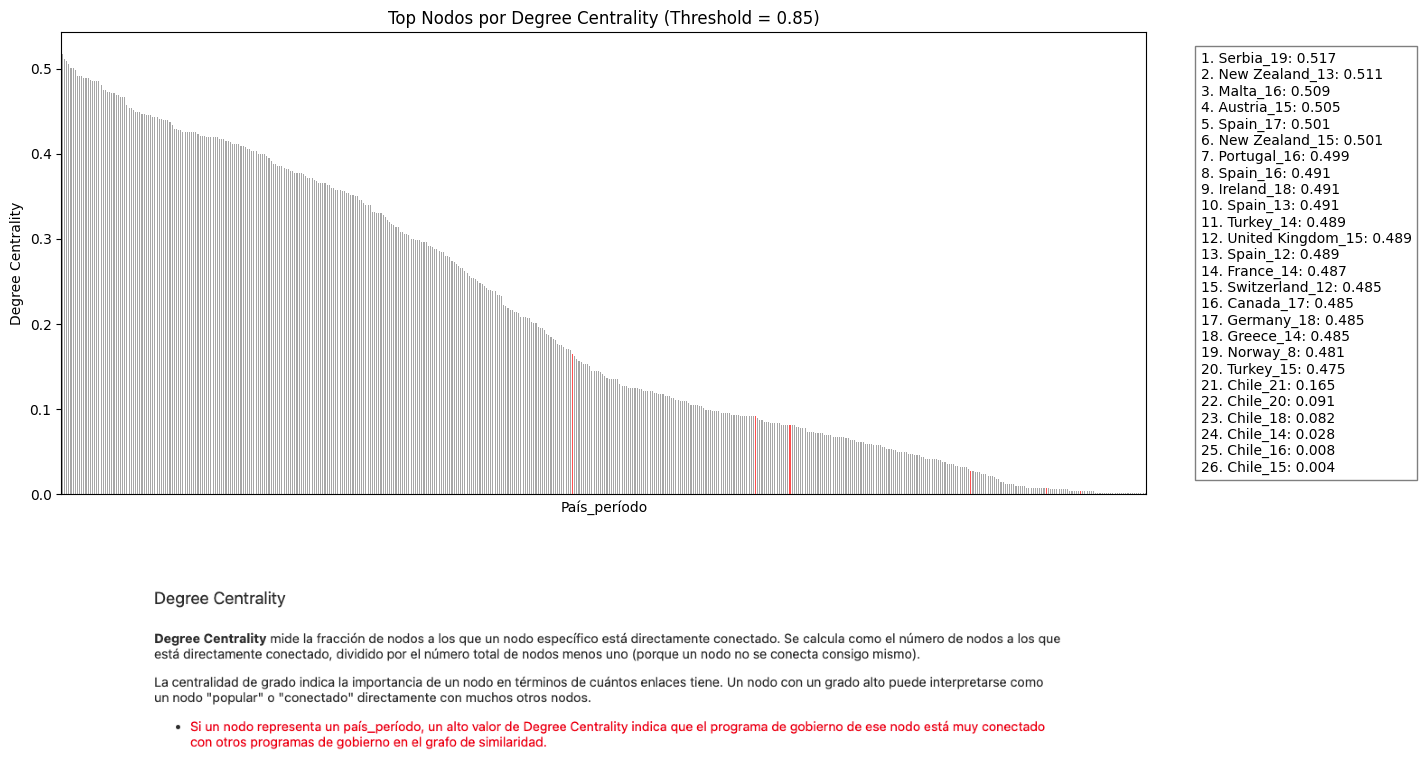

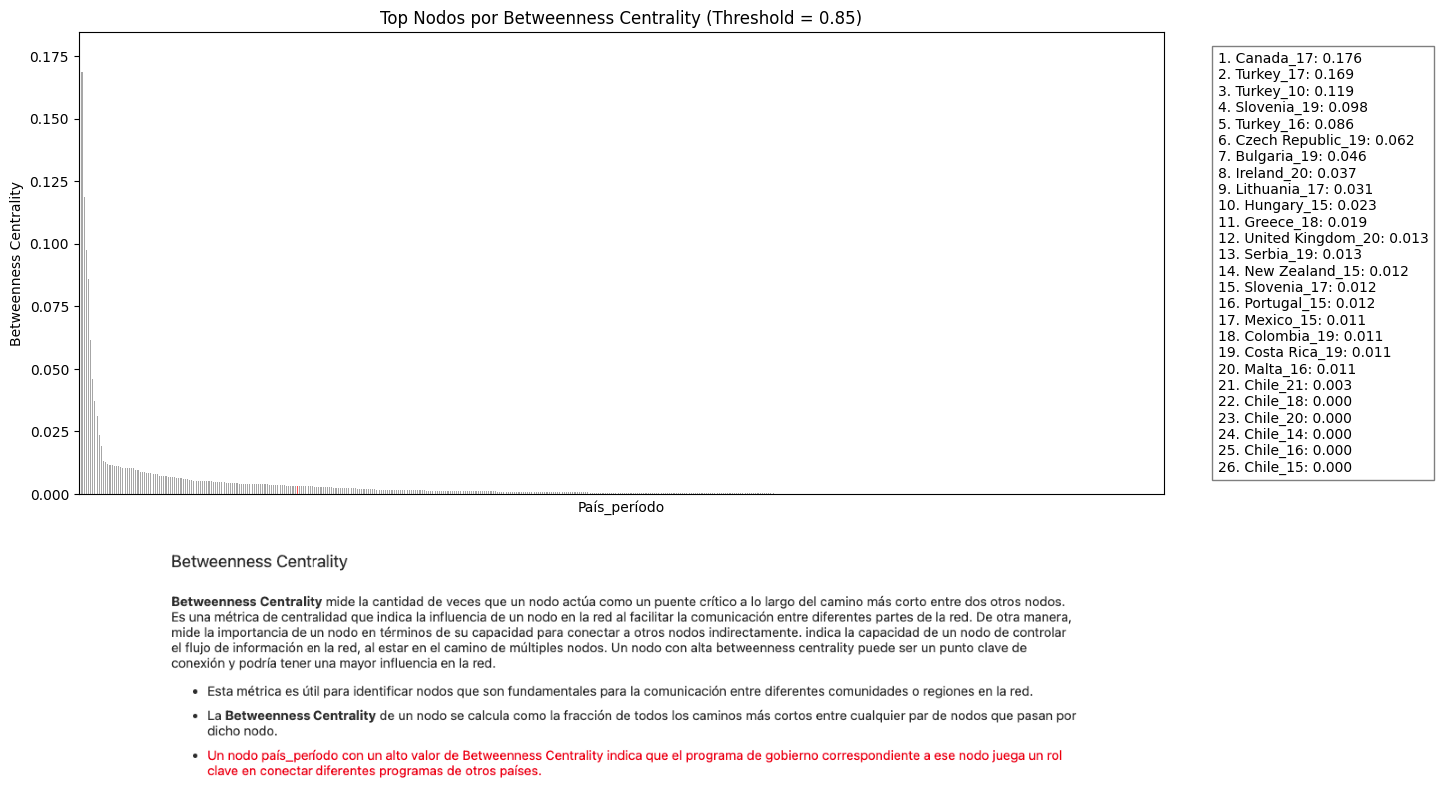

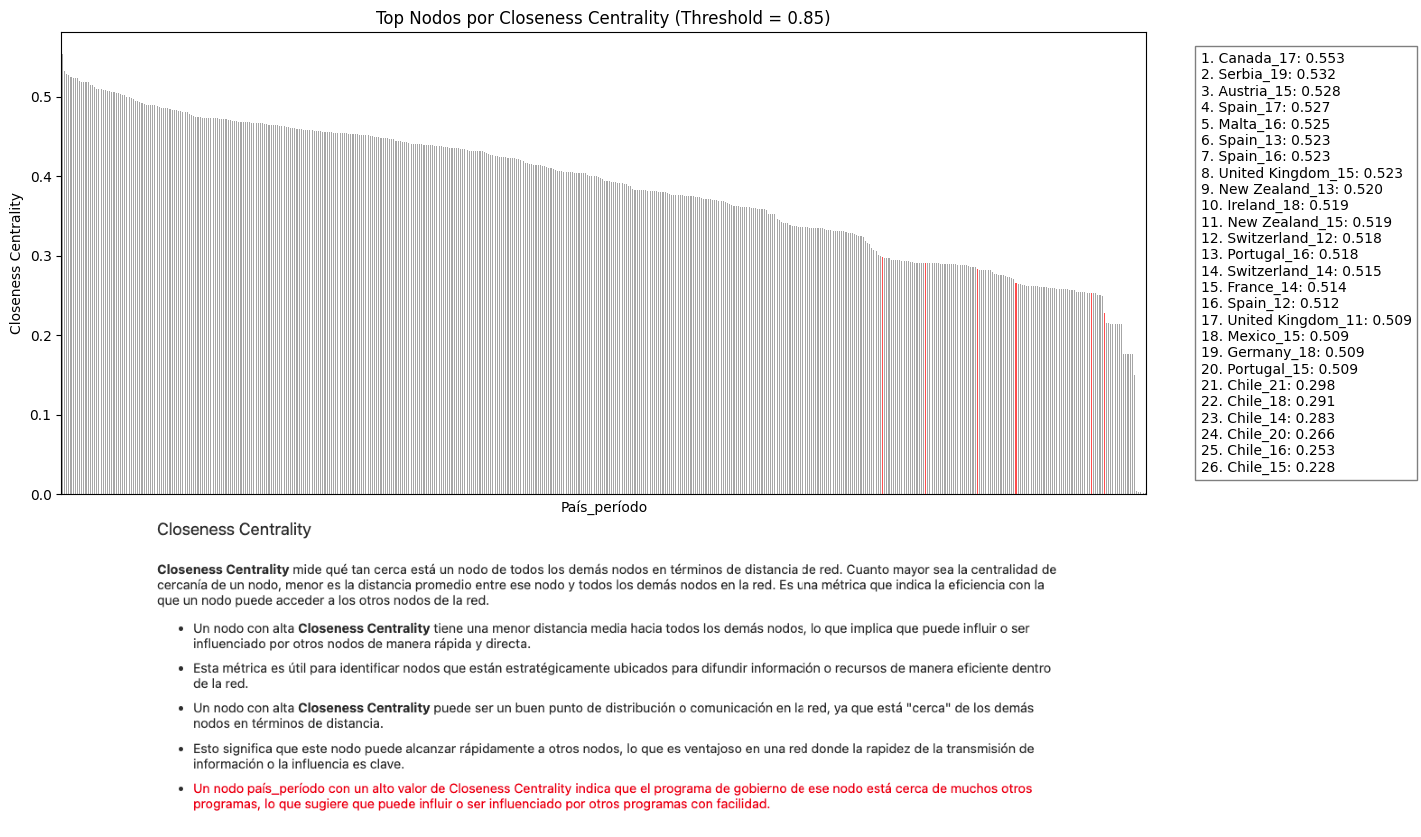

In [144]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def analyze_centrality_with_all_dataframes(centrality_df, threshold, country='Chile'):
    # Crear un dataframe para cada métrica, ordenado de mayor a menor (todos los países)
    all_degree_df = centrality_df[['Degree Centrality']].sort_values(by='Degree Centrality', ascending=False)
    all_betweenness_df = centrality_df[['Betweenness Centrality']].sort_values(by='Betweenness Centrality', ascending=False)
    all_closeness_df = centrality_df[['Closeness Centrality']].sort_values(by='Closeness Centrality', ascending=False)
    
    # Función para asignar colores
    def assign_colors(df, metric):
        return ['red' if country in index else 'gray' for index in df.index]

    # Función para obtener el top 20 y agregar "Chile" si no está presente
    def get_top_20_with_chile(df, metric):
        top_20 = df.head(20)
        if country not in top_20.index:
            chile_row = df.loc[df.index.str.contains(country)]
            top_20 = pd.concat([top_20, chile_row])
        return top_20

    # Función para agregar la lista de top nodos dentro del gráfico
    def add_top_list(ax, df, metric):
        top_list = df.index.tolist()
        values = df[metric].tolist()
        text_list = [f"{i+1}. {node}: {value:.3f}" for i, (node, value) in enumerate(zip(top_list, values))]
        list_text = "\n".join(text_list)
        # Agregar la lista dentro del gráfico
        ax.text(1.05, 0.5, list_text, transform=ax.transAxes, fontsize=10, va='center', bbox=dict(facecolor='white', alpha=0.5))

    # Función para insertar una imagen debajo del gráfico
    def insert_image_below(ax, fig, image_path, zoom=0.5):
        img = mpimg.imread(image_path)
        imagebox = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(imagebox, (0.5, -0.38), frameon=False, xycoords='axes fraction')
        ax.add_artist(ab)

    # Gráfico para Degree Centrality
    fig, ax = plt.subplots(figsize=(14, 6))
    top_degree_df_20 = get_top_20_with_chile(all_degree_df, 'Degree Centrality')
    colors = assign_colors(all_degree_df, 'Degree Centrality')
    all_degree_df['Degree Centrality'].plot(kind='bar', color=colors, alpha=0.7, ax=ax)
    plt.title(f"Top Nodos por Degree Centrality (Threshold = {threshold})")
    plt.xlabel("País_período")
    plt.ylabel("Degree Centrality")
    ax.set_xticks([])  # Ocultar las etiquetas del eje X
    add_top_list(ax, top_degree_df_20, 'Degree Centrality')
    insert_image_below(ax, fig, '../assets/degree.png', zoom=0.65)  # Ajusta el zoom según necesites
    plt.show()
    
    # Gráfico para Betweenness Centrality
    fig, ax = plt.subplots(figsize=(14, 6))
    top_betweenness_df_20 = get_top_20_with_chile(all_betweenness_df, 'Betweenness Centrality')
    colors = assign_colors(all_betweenness_df, 'Betweenness Centrality')
    all_betweenness_df['Betweenness Centrality'].plot(kind='bar', color=colors, alpha=0.7, ax=ax)
    plt.title(f"Top Nodos por Betweenness Centrality (Threshold = {threshold})")
    plt.xlabel("País_período")
    plt.ylabel("Betweenness Centrality")
    ax.set_xticks([])  # Ocultar las etiquetas del eje X
    add_top_list(ax, top_betweenness_df_20, 'Betweenness Centrality')
    insert_image_below(ax, fig, '../assets/betweenness.png', zoom=0.65)  # Ajusta el zoom según necesites
    plt.show()
    
    # Gráfico para Closeness Centrality
    fig, ax = plt.subplots(figsize=(14, 6))
    top_closeness_df_20 = get_top_20_with_chile(all_closeness_df, 'Closeness Centrality')
    colors = assign_colors(all_closeness_df, 'Closeness Centrality')
    all_closeness_df['Closeness Centrality'].plot(kind='bar', color=colors, alpha=0.7, ax=ax)
    plt.title(f"Top Nodos por Closeness Centrality (Threshold = {threshold})")
    plt.xlabel("País_período")
    plt.ylabel("Closeness Centrality")
    ax.set_xticks([])  # Ocultar las etiquetas del eje X
    add_top_list(ax, top_closeness_df_20, 'Closeness Centrality')
    insert_image_below(ax, fig, '../assets/closeness.png', zoom=0.65)  # Ajusta el zoom según necesites
    plt.show()
    
    return all_degree_df, all_betweenness_df, all_closeness_df, top_degree_df_20, top_betweenness_df_20, top_closeness_df_20

# Llamar a la función y generar los gráficos y mostrar los dataframes
all_degree_df, all_betweenness_df, all_closeness_df, top_degree_df_20, top_betweenness_df_20, top_closeness_df_20 = analyze_centrality_with_all_dataframes(centrality_df, threshold)


<h2>Impacto del <code>threshold</code> en las métricas de centralidad</h2>

<p>En realidad, <strong>sí deberían variar las métricas de centralidad</strong> al cambiar el <code>threshold</code>. Aquí está la explicación de por qué:</p>

<h3>Efecto del <code>threshold</code></h3>
<ul>
    <li>El <code>threshold</code> determina qué conexiones (o enlaces) se incluyen en el grafo. Si aumentas o disminuyes el <code>threshold</code>, estarás modificando la estructura del grafo al agregar o eliminar enlaces entre los nodos en función de la correlación.</li>
    <li>Esto significa que al variar el <code>threshold</code>, la cantidad de conexiones entre nodos cambiará, lo cual influye directamente en cómo se calculan las métricas de centralidad.</li>
</ul>

<h3>Cambios en Degree Centrality</h3>
<ul>
    <li><strong>Degree Centrality</strong> depende del número de conexiones directas de un nodo. Si aumentas el <code>threshold</code>, es probable que se eliminen algunas conexiones más débiles, reduciendo el número de conexiones directas de ciertos nodos. Por lo tanto, el <strong>Degree Centrality</strong> de algunos nodos disminuirá al aumentar el <code>threshold</code> y podría aumentar al reducirlo.</li>
</ul>

<h3>Cambios en Betweenness Centrality</h3>
<ul>
    <li><strong>Betweenness Centrality</strong> mide cuántos caminos cortos pasan a través de un nodo. Si los enlaces se eliminan debido a un aumento en el <code>threshold</code>, los caminos más cortos entre nodos también se verán afectados. Algunos nodos que antes conectaban dos partes de la red podrían dejar de hacerlo, disminuyendo su <strong>Betweenness Centrality</strong>.</li>
</ul>

<h3>Cambios en Closeness Centrality</h3>
<ul>
    <li><strong>Closeness Centrality</strong> se basa en la distancia promedio entre un nodo y todos los demás. Si se eliminan enlaces al aumentar el <code>threshold</code>, la distancia entre nodos podría incrementarse. Esto afectará las distancias mínimas y, por lo tanto, la <strong>Closeness Centrality</strong> cambiará al variar el <code>threshold</code>.</li>
</ul>

<h3>Resumen</h3>
<p>Cuando cambias el <code>threshold</code>, la estructura de la red se modifica (al agregar o eliminar enlaces). Dado que todas las métricas de centralidad dependen de la estructura de la red, es <strong>esperable que las métricas de centralidad cambien</strong> en función del <code>threshold</code>. Por eso, si el <code>threshold</code> varía, las métricas que calculaste también podrían cambiar.</p>


#### 14 Oct 2024
#### Temas por revisare en este Notebook:
*   * Ver porqué los últimos feature vectors usados dan correlaciones -1, 0 ó 1
*   * En este notebook dejé repetidos el tema 1 y tema 3: el notebook corre bien, y las correlaciones son normales
*   **NOTA: El número de nodos es demasiado grande (811) para un threshiold de 0.85**
*   * Acuerdo con profesora guía:
*   * 1.Analizar las curvas del notebook Pruebas_Chile, usando valores absolutos y comparar
*   * 2.Validar los datos nuevamente y ver si explican bien la realidad
*   * 3.Luego de 1 y 2: 
*       * Elegir un tema
*       * Hacer la red de correlaciones de nodos todos los países con todos los países (debiera ser una red cuadrada, con 1 en la diagonal)
*       * Fijar un threshold
*       * Fijar una ventana (quedará un nodo por país). Debe quedar un nodo por país.
*       * Analizar 